In [79]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import open3d as o3d
from segment_lidar import samlidar, view

labeled_tif_path = "/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/labeled.tif"
raster_tif_path = "/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/raster.tif"

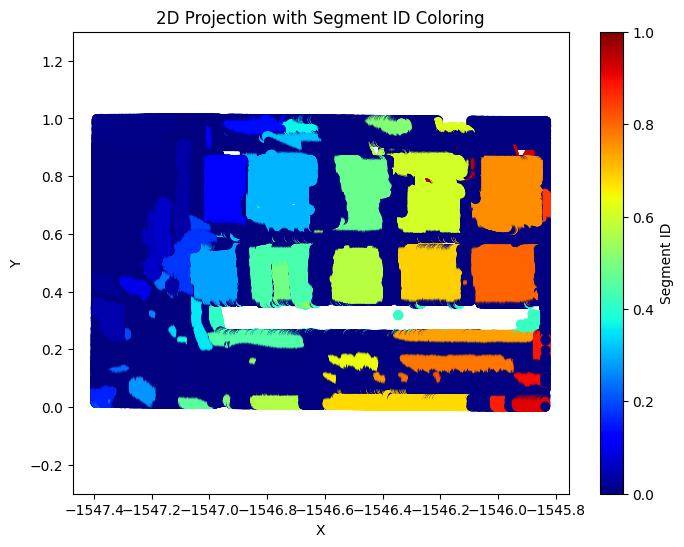

In [40]:
def show_segmentid_image(filename):    
    las = laspy.read(filename)

    x, y, z, segment_id, r, g, b = las.x, las.y, las.z,las.segment_id, las.red, las.green, las.blue

    # Normalize segment_id for color mapping
    min_val, max_val = segment_id.min(), segment_id.max()
    segment_id_norm = (segment_id - min_val) / (max_val - min_val) if min_val != max_val else np.zeros_like(segment_id)

    # Normalize x
    min_val, max_val = y.min(), y.max()
    x_norm = (x - min_val) / (max_val - min_val) 
    # Normalize y
    y_norm = (y - min_val) / (max_val - min_val) 

    # Plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(x_norm, y_norm, c=segment_id_norm, cmap="jet")  
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2D Projection with Segment ID Coloring")
    plt.axis("equal")
    plt.colorbar(sc, label="Segment ID") 
    plt.show()

show_segmentid_image("segmented.las")

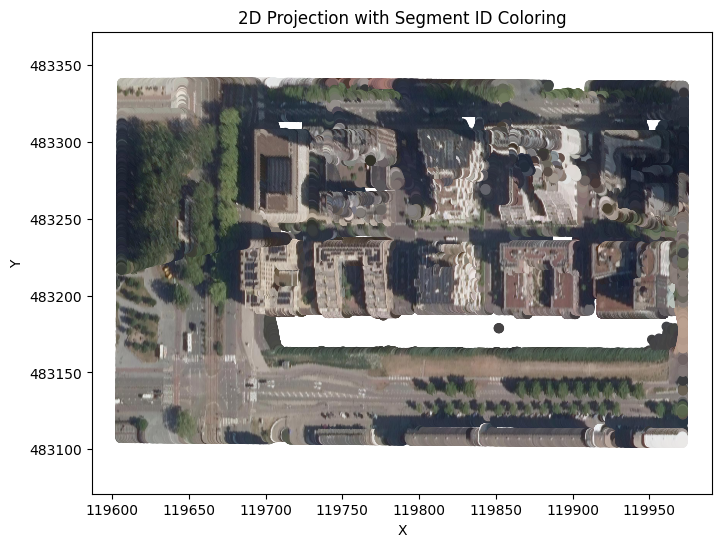

In [ ]:
def show_rgb_image(filename):
    las = laspy.read(filename)

    x, y, z, r, g, b = las.x, las.y, las.z, las.red, las.green, las.blue
    r = r * (255/65535)
    g = g * (255/65535)
    b = b * (255/65535)
    colors = []
    # rgb arrays to hex
    for i in range(len(r)): 
        color = '#%02x%02x%02x' % (int(r[i]), int(g[i]), int(b[i]))
        colors.append(color)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(x, y, c=colors, cmap="jet")  
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2D Projection with Segment ID Coloring")
    plt.axis("equal")
    plt.show()
    
show_rgb_image("segmented.las")

mask done


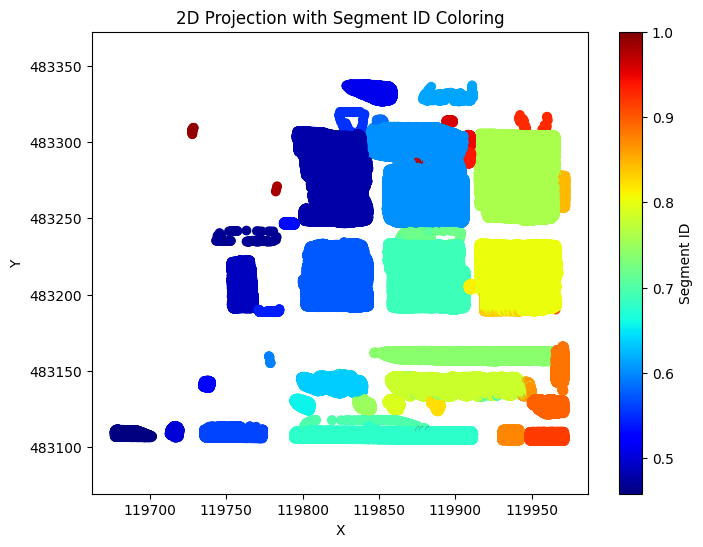

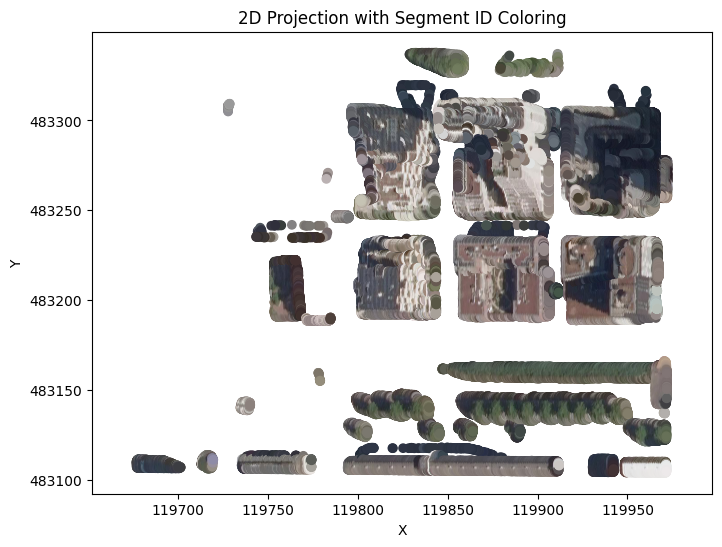

In [42]:
# Masks
def show_segmentid_image_mask(filename, mask_value):
    las = laspy.read(filename)
    x, y, z, segment_id = las.x, las.y, las.z,las.segment_id

    x_mask = list()
    y_mask = list()
    segment_id_norm_mask = list()
    real_color_mask = list()

    # Normalize segment_id for color mapping
    min_val, max_val = segment_id.min(), segment_id.max()
    segment_id_norm = (segment_id - min_val) / (max_val - min_val) if min_val != max_val else np.zeros_like(segment_id)
    
    r, g, b = las.red, las.green, las.blue
    r = r * (255/65535)
    g = g * (255/65535)
    b = b * (255/65535)
    colors = []
    # rgb arrays to hex
    for i in range(len(r)): 
        color = '#%02x%02x%02x' % (int(r[i]), int(g[i]), int(b[i]))
        colors.append(color)

    for i in range(len(segment_id_norm)):
        if segment_id_norm[i] > mask_value:
            x_mask.append(x[i])
            y_mask.append(y[i])
            segment_id_norm_mask.append(segment_id_norm[i])
            real_color_mask.append(colors[i])
            
            
    print("mask done")
    # Plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(x_mask, y_mask, c=segment_id_norm_mask, cmap="jet")  
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2D Projection with Segment ID Coloring")
    plt.axis("equal")
    plt.colorbar(sc, label="Segment ID") 
    plt.show()
    
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(x_mask, y_mask, c=real_color_mask, cmap="jet")  
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2D Projection with Segment ID Coloring")
    plt.axis("equal")
    plt.show()
    
show_segmentid_image_mask("segmented.las", 0.45)

# Downsampling images and apply segment lidar

In [43]:

# Converting las files to PCD, suprisely open3D cant read LAS files...

def laspy_to_o3d(las) -> o3d.t.geometry.PointCloud:
    # get points
    points = np.vstack((las.x, las.y, las.z)).transpose()
    print("point len : ",  len(points))

    # make blank cloud
    pcd = o3d.geometry.PointCloud()

    # add x,y,z to o3d cloud
    pcd.points = o3d.utility.Vector3dVector(points)

    # if rgb present, convert to o3d colors
    all_dims = list(las.point_format.dimension_names)[3:]
        
    '''if "segment_id" in all_dims:
        print("segment_id")
        colors = np.vstack((las.red, las.green, las.blue, las.segment_id)).transpose()
        pcd_t.point.colors = o3d.core.Tensor(colors)
        all_dims.remove("blue")
        all_dims.remove("green")
        all_dims.remove("red")
        all_dims.remove("segment_id")'''
        
    
    if "red" in all_dims and "green" in all_dims and "blue" in all_dims:
        colors = np.vstack((las.red, las.green, las.blue)).transpose()
        pcd.colors = o3d.utility.Vector3dVector(colors)
        all_dims.remove("blue")
        all_dims.remove("green")
        all_dims.remove("red")
    

    # add other attributes
    attributes = all_dims

    '''
    for attr in attributes:
        #print("crash here : ", attr)
        # If only has single value, this is much faster
        if np.all(las[attr] == las[attr][0]):
            # Fill with the single value
            las_attr = np.full((len(las[attr]), 1), las[attr][0])
        else:
            # assumes only 1d.  Otherwise you need vstack which is slower
            las_attr = np.array(las[attr])[:, None]

        pcd.points[attr] = o3d.utility.Vector3dVector(las_attr)
        '''
    print("attributes done")
    return pcd


In [44]:
def voxel_downsample(pcd, voxelvalue = 1): # Increase voxel size to reduce memory usage
    print("Voxel downsample function") 
    '''
    ply_point_cloud = input_file
    # This 2 lines in case of we want to pass an input file
    pcd = o3d.io.read_point_cloud(filename=ply_point_cloud)
    '''

    '''
    If your pointcloud file is expressed in meters, voxel_size=0.05 will mean the voxel grid will be made up of voxels measuring 5 x 5 x 5 cm. 
    After filtering the pointcloud density is reduced so that you have only one point per such voxel. 
    '''
    print(pcd)
    downsample = pcd.voxel_down_sample(voxelvalue)
    print("before : ", pcd, ", after : ", downsample)
    #print("before : ", np.asarray(pcd.colors))
    #print("after : ", np.asarray(downsample.colors))
    return downsample

In [45]:
def show_image_pcd(input_file):
    print("Show image fuction")
    # Read the PCD file using open3d
    #pcd = o3d.io.read_point_cloud(input_file)
    pcd = input_file
    
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    # Where can i get the segment_id ?
    
    x, y = points[:, 0], points[:, 1]
    
    r = colors[:, 0] * (255/65535) 
    g = colors[:, 1] * (255/65535)
    b = colors[:, 2] * (255/65535)
    #print(r)
    colors = []
    # rgb arrays to hex
    for i in range(len(r)): 
        color = '#%02x%02x%02x' % (int(r[i]), int(g[i]), int(b[i]))
        colors.append(color)
            
    # Plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(x, y, c=colors, cmap="jet")  
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2D Projection with Segment ID Coloring")
    plt.axis("equal")
    plt.colorbar(sc, label="Segment ID") 
    plt.show()

point len :  3402226
attributes done
Voxel downsample function
PointCloud with 3402226 points.
before :  PointCloud with 3402226 points. , after :  PointCloud with 262994 points.
Show image fuction


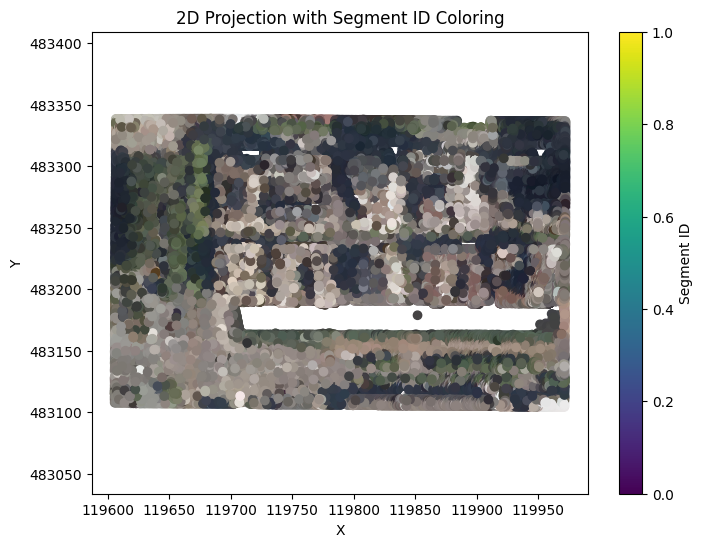

In [62]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

las = laspy.read("segmented.las")
pcd = laspy_to_o3d(las)

filename = "downsampled.pcd"
down_file = voxel_downsample(pcd, 0.9)
#print(np.asarray(down_file.colors))
o3d.io.write_point_cloud(filename, down_file)

# ------------------------------------------------------------
# For some reason (i don't know), write point cloud doesnt save the colors
# ------------------------------------------------------------

show_image_pcd(down_file)


## Run lidar segment on downsampled image

In [63]:
filename="downsampled.pcd"
from segment_lidar import samlidar, view
import pylas
import open3d as o3d
import numpy as np

After run the program on top, downsampled.pcd file will be created, we need to apply lidar-segmentation on it.

But the accepted files formats are : [.laz, .las], not pcd so we need to convert them first

In [76]:
def convert_pcd_to_las(pcd_file=None, point_cloud=None, las_file="downsampled.las"):
    if(pcd_file is None and point_cloud is None):
        print("No input file")
        return
    # Read the PCD file
    if point_cloud is None:
        pcd = o3d.io.read_point_cloud(pcd_file)
    else:
        pcd = point_cloud
    
    # Extract points and colors from the PCD file
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    
    r = colors[:, 0]
    g = colors[:, 1]
    b = colors[:, 2]
    
    # Create a LAS file with RGB fields
    las = pylas.create(point_format_id=3)
    las.x = points[:, 0]
    las.y = points[:, 1]
    las.z = points[:, 2]
    las.red = r
    las.green = g
    las.blue = b
    
    # Write the LAS file
    las.write(las_file)


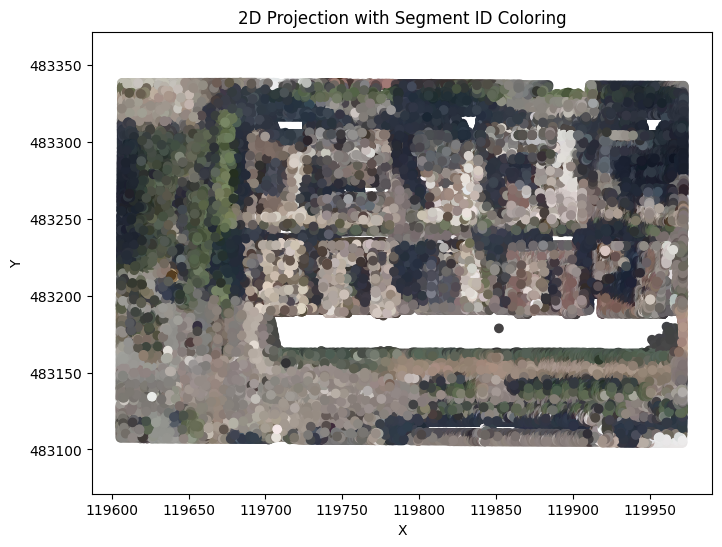

In [77]:
# Create the las file
las_filename = "downsampled.las"
convert_pcd_to_las(point_cloud=down_file, las_file=las_filename) 
show_rgb_image(las_filename)

Reading downsampled.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is completed in 0.10 seconds. The point cloud contains 262994 points.

/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/labeled.tif  now OK
- Generating raster image...
- Saving raster image...
- Applying segment-geospatial to raster image...
- Saving segmented image...
- Generating segment IDs...
Segmentation is completed in 207.30 seconds. Number of instances: 61

Writing the segmented point cloud to segmented_downsample.las...
Writing is completed in 0.24 seconds.



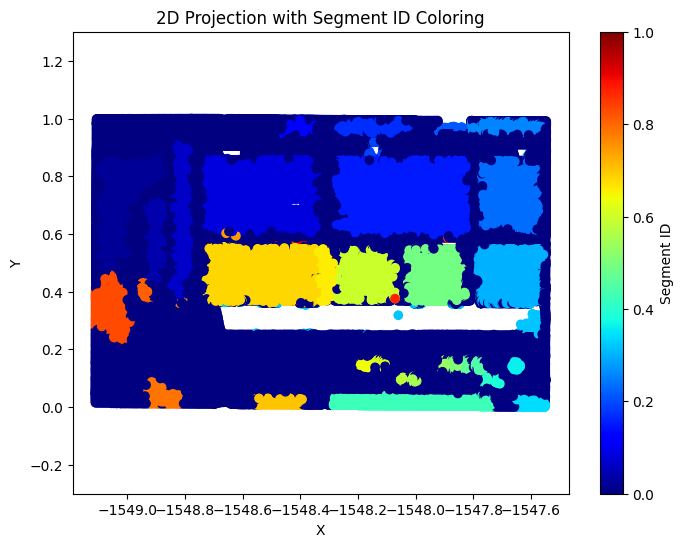

In [80]:
#Obviously this function could take a while....
def compute_segment_lidar(input_file, save_path):
    viewpoint = view.TopView()

    model = samlidar.SamLidar(ckpt_path="sam_vit_h_4b8939.pth")
    points = model.read(input_file)
    labels, *_ = model.segment(points=points, view=viewpoint, labels_path=labeled_tif_path)
    model.write(points=points, segment_ids=labels, save_path=save_path)
    
compute_segment_lidar(las_filename, "segmented_downsample.las")
show_segmentid_image("segmented_downsample.las")